# Planning & Overview

* `pnl`, `x`, `q`, `o` - PnL, wealth, inventory, offset
* `levels`, `queues` - L5 price levels and queues
* `r`, `rb`, `ra`, `la`, `lb`, `pb`, `pb` - Reservation price, quotes, lambdas, fill probabilities
* `db`, `da`, `db1`, `da1` - Distance from quote to mid, distance from quote to best price level 
* `f` - Number of trades

In [1]:
import pandas as pd
import numpy as np
import math
import random
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('darkgrid')

## Parameter Estimation Helpers

In [2]:
def resample_prices(ms, N):

    levels = pd.read_csv('./data/levels.csv',index_col='time', parse_dates=True)
    levels.index = pd.to_timedelta(levels.index)
    levels['mid'] = (levels['a1'] + levels['b1'])/2
    levels = levels.resample(f'{ms}ms').mean().ffill().div(1000)
    logrets = np.log(levels.mid) - np.log(levels.mid.shift(1))
    sigma = logrets.std() * np.sqrt(N)

    return levels, levels.mid, sigma

clean_levels, s, sigma = resample_prices(100,23400)

In [3]:
clean_levels

,a5,a4,a3,a2,a1,b1,b2,b3,b4,b5,mid
time,,,,,,,,,,,
0 days 00:00:00,2244.000000,2242.500000,2240.000000,2239.900000,2239.500000,2231.800000,2230.700000,2230.400000,2230.000000,2226.200000,2235.650000
0 days 00:00:00.100000,2242.541379,2240.086207,2239.903448,2239.610345,2239.500000,2238.058621,2237.037931,2235.741379,2234.889655,2233.813793,2238.779310
0 days 00:00:00.200000,2242.541379,2240.086207,2239.903448,2239.610345,2239.500000,2238.058621,2237.037931,2235.741379,2234.889655,2233.813793,2238.779310
0 days 00:00:00.300000,2243.462222,2242.395556,2241.962222,2241.320000,2239.882222,2237.500000,2236.500000,2236.155556,2235.777778,2234.977778,2238.691111
0 days 00:00:00.400000,2244.000000,2243.000000,2242.500000,2242.400000,2240.000000,2237.500000,2236.566667,2236.200000,2235.700000,2235.050000,2238.750000
...,...,...,...,...,...,...,...,...,...,...,...
0 days 06:29:59.500000,2206.900000,2206.700000,2206.500000,2206.400000,2206.200000,2205.100000,2205.000000,2204.800000,2204.700000,2204.600000,2205.650000
0 days 06:29:59.600000,2206.900000,2206.700000,2206.500000,2206.400000,2206.200000,2205.100000,2205.000000,2204.800000,2204.700000,2204.600000,2205.650000
0 days 06:29:59.700000,2206.900000,2206.700000,2206.500000,2206.400000,2206.200000,2205.100000,2205.000000,2204.800000,2204.700000,2204.600000,2205.650000


## Simulation Helpers

In [4]:

def create_arrays(N):

    pnl, x, q = np.empty((N)), np.empty((N)), np.empty((N))
    pnl[0], x[0], q[0] = 0, 0, 0
    o, r, ra, rb, rs = np.empty((N)), np.empty((N)), np.empty((N)), np.empty((N)), np.empty((N))
    db, da = np.empty((N)), np.empty((N))
    lb, la = np.empty((N)), np.empty((N))
    pb, pa = np.empty((N)), np.empty((N))
    f = np.empty((N))

    return pnl, x, q, o, r, rb, ra, rs, db, da, lb, la, pb, pa, f



# Simulation

In [5]:



def simulate(ms, gamma, A, k, reduce=False):

    SECONDS_PER_DAY = 60 * 60 * 6.5
    time_step = ms/1e3
    N = int(SECONDS_PER_DAY/time_step)
    T = 1
    dt = 1/N

    clean_levels, s, sigma = resample_prices(ms, N)
    ds = s.diff().fillna(0)
    m = ds.shift(-5).rolling(5).mean().fillna(0)

    
    pnl, x, q, o, r, rb, ra, rs, db, da, lb, la, pb, pa, f  = create_arrays(N)

    for i in range(N-1):

        # Reserve price
        o[i] = - q[i] * gamma * sigma**2 * (T-dt*i) * 1e4
        r[i] = s[i] + o[i] 

        # Reserve spread
        rs[i] = gamma * sigma**2 * (T- dt*i) + 2 / gamma * math.log(1+gamma/k)    

        # optimal quotes
        ra[i] = r[i] + rs[i]/2
        rb[i] = r[i] - rs[i]/2

        # Cap our bid ask
        if ra[i] <= clean_levels.a1[i]:
            ra[i] = clean_levels.a1[i]
        
        if rb[i] >= clean_levels.b1[i]:
            rb[i] = clean_levels.b1[i]

        # Reserve deltas
        da[i] = ra[i] - s[i]
        db[i] = s[i] - rb[i]

        # Intensities
        lb[i] = A * math.exp(-k*db[i])
        la[i] = A * math.exp(-k*da[i])

        # Simulating probability of quotes getting hit/lifted
        yb = random.random()
        ya = random.random()

        pb[i] = (1 - math.exp(-lb[i]*(ms/1e3))) 
        pa[i] = (1 - math.exp(-la[i]*(ms/1e3))) 

        dNa, dNb = 0, 0

        if ya < pa[i]:
            dNa = 1
        if yb < pb[i]:
            dNb = 1
        
        f[i] = dNa + dNb
        q[i+1] = q[i] - dNa + dNb
        x[i+1] = x[i] + ra[i]*dNa - rb[i]*dNb
        pnl[i+1] = x[i+1] + q[i+1]*s[i]

    if reduce:
        return pnl[-1]

    data = {
        's': s,
        'ds': ds,
        'ms': m,
        'q': q,
        'o': o,
        'r': r,
        'rb': rb,
        'ra': ra,
        'rs': rs,
        'db': db,
        'da': da,
        'b2': clean_levels.b2,
        'b1': clean_levels.b1,
        # 'spr': clean_levels.a1 - clean_levels.b1,
        'a1': clean_levels.a1,
        'a2': clean_levels.a2,
        'lb': lb,
        'la': la,
        'pb': pb,
        'pa': pa,
        'pd': pa - pb,
        'pnl': pnl,
        'f': f.cumsum()
    }
    df = pd.DataFrame(data)
    df.set_index(s.index, inplace=True)
    df = df.iloc[:-1,:]

    


    return df

In [6]:
SECONDS_PER_DAY = 60 * 60 * 6.5
time_step = 100/1e3
N = int(SECONDS_PER_DAY/time_step) 
ms = 1e3

A, k = 0.34, 2.13
gamma = 0.1
np.random.seed(42)
df = simulate(ms, gamma, A, k)

In [7]:
df

,s,ds,ms,q,o,r,rb,ra,rs,db,...,b1,a1,a2,lb,la,pb,pa,pd,pnl,f
time,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:00,2238.764732,0.000000,0.000000,0.0,-0.000000,2238.764732,2237.617857,2239.911607,0.917605,1.146875,...,2237.617857,2239.911607,2241.055357,0.029551,0.029551,0.029118,0.029118,0.000000e+00,0.000000,0.0
0 days 00:00:01,2240.193182,1.428450,0.000000,0.0,-0.000000,2240.193182,2238.400000,2241.986364,0.917605,1.793182,...,2238.400000,2241.986364,2242.245455,0.007459,0.007459,0.007432,0.007432,-1.443290e-14,0.000000,0.0
0 days 00:00:02,2240.622222,0.429040,0.000000,0.0,-0.000000,2240.622222,2238.844444,2242.400000,0.917605,1.777778,...,2238.844444,2242.400000,2242.500000,0.007708,0.007708,0.007679,0.007679,-1.476597e-14,0.000000,0.0
0 days 00:00:03,2240.450000,-0.172222,0.000000,0.0,-0.000000,2240.450000,2238.900000,2242.000000,0.917605,1.550000,...,2238.900000,2242.000000,2242.400000,0.012521,0.012521,0.012443,0.012443,-1.199041e-14,0.000000,0.0
0 days 00:00:04,2240.230000,-0.220000,-0.056750,0.0,-0.000000,2240.230000,2238.900000,2241.560000,0.917605,1.330000,...,2238.900000,2241.560000,2242.310000,0.020006,0.020006,0.019807,0.019807,0.000000e+00,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 06:29:54,2205.650000,0.037500,-0.009032,8.0,-0.000256,2205.649744,2205.190948,2206.108540,0.917592,0.459052,...,2205.300000,2206.000000,2206.171429,0.127889,0.128029,0.120049,0.120172,1.229111e-04,2339.742349,3802.0
0 days 06:29:55,2205.820000,0.170000,0.000000,8.0,-0.000214,2205.819786,2205.360990,2206.278583,0.917592,0.459010,...,2205.574000,2206.066000,2206.202000,0.127901,0.128017,0.120059,0.120162,1.024259e-04,2340.042349,3802.0
0 days 06:29:56,2206.050000,0.230000,0.000000,8.0,-0.000171,2206.049829,2205.591033,2206.508625,0.917592,0.458967,...,2205.900000,2206.200000,2206.500000,0.127912,0.128006,0.120070,0.120152,8.194072e-05,2341.402349,3802.0


In [8]:
df.to_pickle('./data/df.pkl')
df['db1'] = df.b1 - df.rb
df['da1'] = df.a1 - df.ra

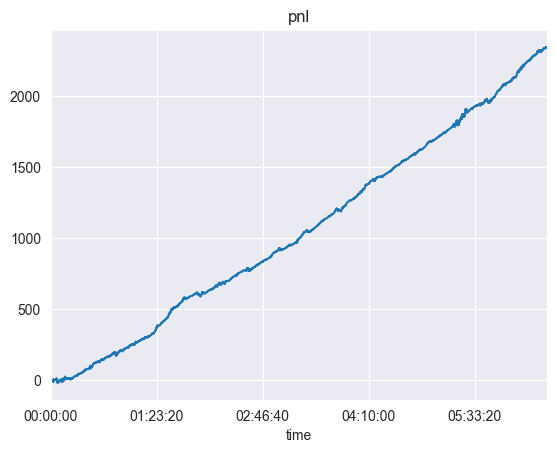

In [9]:
df.pnl.plot(title='pnl')
plt.savefig(fr'C:\Users\Ryan\Desktop\website\analytic-musings.com\assets\images\HFTinLOB\pnl.png')

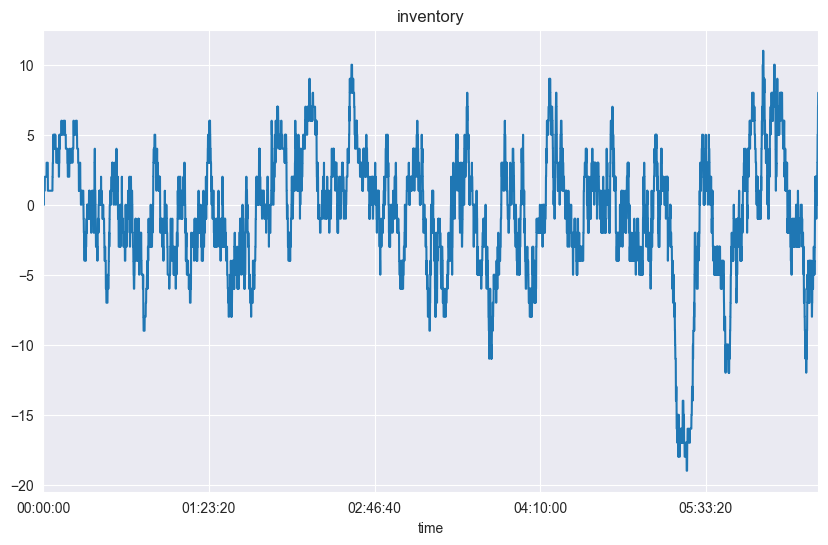

In [10]:
df.q.plot(figsize=(10,6), title='inventory')
plt.savefig(fr'C:\Users\Ryan\Desktop\website\analytic-musings.com\assets\images\HFTinLOB\inventory.png')

In [11]:
df = pd.read_pickle('./data/df.pkl')

sample = df[(df.index > '01:00:00')&(df.index <"2:30:00")]
sample['db1'] = sample.b1 - sample.rb
sample['da1'] = sample.a1 - sample.ra

C:\Users\Ryan\AppData\Local\Temp\ipykernel_84236\238524499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['db1'] = sample.b1 - sample.rb
C:\Users\Ryan\AppData\Local\Temp\ipykernel_84236\238524499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['da1'] = sample.a1 - sample.ra


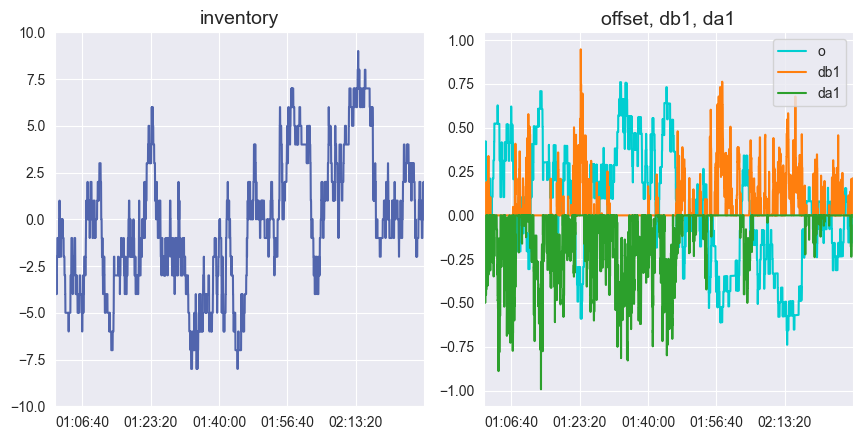

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import datetime
from matplotlib import dates
from matplotlib import pyplot as plt
x = 4.5
fig, ax = plt.subplots(1,2, figsize=(x*1.94,x))



colors = {'o': 'darkturquoise', 'db1': 'tab:orange', 'da1':'tab:green'}


sample.q.plot(ax=ax[0], color='#5165ad', xlabel=None, ylim=[-10,10])
sample[['o', 'db1', 'da1']].plot(ax=ax[1], xlabel=None, color=colors)
# ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[0].set_title('inventory', size=14)
ax[1].set_title('offset, db1, da1', size=14)
# plt.subplots_adjust(left=0.06, right=0.98, top=0.93, bottom=0.07)
plt.tight_layout()
plt.savefig(r"C:\Users\Ryan\Desktop\website\analytic-musings.com\assets\images\HFTinLOB\osc.png", dpi=130)


In [13]:
sample

,s,ds,ms,q,o,r,rb,ra,rs,db,...,a2,lb,la,pb,pa,pd,pnl,f,db1,da1
time,,,,,,,,,,,,,,,,,,,,,
0 days 01:00:01,2239.300000,0.000000,-0.284151,-2.0,0.211405,2239.511405,2238.800000,2239.970206,0.917603,0.500000,...,2239.900000,0.117207,0.081566,0.110599,0.078328,-3.227165e-02,227.607280,404.0,0.000000,-0.170206
0 days 01:00:02,2239.300000,0.000000,-0.290000,-2.0,0.211394,2239.511394,2238.800000,2239.970195,0.917603,0.500000,...,2239.900000,0.117207,0.081567,0.110599,0.078329,-3.226994e-02,227.607280,404.0,0.000000,-0.170195
0 days 01:00:03,2239.233333,-0.066667,-0.272667,-2.0,0.211383,2239.444717,2238.800000,2239.903518,0.917603,0.433333,...,2239.833333,0.135091,0.081569,0.126363,0.078331,-4.803211e-02,227.607280,404.0,0.000000,-0.236851
0 days 01:00:04,2238.487037,-0.746296,-0.067407,-2.0,0.211373,2238.698410,2237.633333,2239.340741,0.917603,0.853704,...,2239.572222,0.055178,0.055178,0.053683,0.053683,-1.011413e-13,227.740614,404.0,0.000000,0.000000
0 days 01:00:05,2237.950000,-0.537037,0.026667,-2.0,0.211362,2238.161362,2237.100000,2238.800000,0.917603,0.850000,...,2239.100000,0.055615,0.055615,0.054096,0.054096,-5.095924e-14,229.233206,404.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 02:29:55,2239.200000,0.000000,-0.200000,1.0,-0.076905,2239.123095,2238.600000,2239.800000,0.917600,0.600000,...,2239.900000,0.094722,0.094722,0.090374,0.090374,-8.348877e-14,765.520639,1247.0,0.000000,0.000000
0 days 02:29:56,2239.150000,-0.050000,-0.210769,1.0,-0.076900,2239.073100,2238.600000,2239.700000,0.917600,0.550000,...,2239.800000,0.105367,0.105367,0.100005,0.100005,9.181544e-14,765.520639,1247.0,0.000000,0.000000
0 days 02:29:57,2239.080000,-0.070000,-0.206000,1.0,-0.076894,2239.003106,2238.530000,2239.630000,0.917600,0.550000,...,2239.780000,0.105367,0.105367,0.100005,0.100005,-9.181544e-14,765.470639,1247.0,0.000000,0.000000


# Multiple Runs

In [14]:

pnls = []
for sim in range(100):
    pnl = simulate(ms, gamma, A, k, reduce=True)
    pnls.append(pnl)


In [ ]:

pnl_df = pd.DataFrame(pnls, columns=['pnl'])

In [ ]:
pnl_df.plot(kind='hist',bins=30)

In [ ]:
df.q.plot()

# Bid-Ask Plot

In [ ]:

sample = df[(df.index > '1:25:00')&(df.index <"01:30:00")]
sample[['s', 'rb', 'ra', 'r']].plot()

In [ ]:
sample